# Social Computing - Summer 2021
# Exercise 3 - Finding Groups: Clustering Methods

Clustering aims at grouping data-points according to certain characteristics of interest. The groupings at maximizing intra-cluster cohesion and inter-cluster de-cohesion. In this exercise, we will take a look at Louvain clustering and a comparison between K-means and Gaussian Mixture Models.

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import copy
import random

## Task 3.1: Louvain Clustering 
In this section of the exercise, you will look at a clustering method which is an alternative to the Newmann Girvan Method from the lecture, the Louvain algorithm. It is an efficient algorithm for computing graph clusterings. Your task will be to implement it.

### Louvain Algorithm
The central goal of this algorithm is to sequentially merge nodes into clusters based on modularity as a local optimality criterion. Even though the algorithm is "greedy" and not guaranteed to find the best clustering, it gives quite good results for detecting communities and groups. 

We start with singletons (each node in its own cluster) and pick a node $i$. For each friend $j$ of $i$, we calculate Modularity values that result from adding $i$ to the singleton cluster $j$ (forming a new 2-cluster) or that result from adding $i$ to the non-singleton cluster that contains $j$. We merge $i$ with that $j$ for which the gain in Modularity is highest. We do this sequentially for all nodes $i$ in the graph. 

Then, each new cluster is replaced by a new node representing the cluster. Edges within the cluster are translated into self-edges of that new cluster node. We can then go back to the first step and iterate. 

Modularity for a graph with adjacency matrix $A_{ij}$ is by the difference between the number (or added weight) of intra-cluster edges in the actual graph $G(V,E)$ and  the number (or added weight) of intra-cluster edges in a random version of the graph where we keep the degrees (or added edge weights) of each node as in the original graph: 

$$Q = \frac{1}{2m}\sum_{i,j\in V}[A_{ij}-\frac{k_ik_j}{2m}]\delta(c_i, c_j)$$

where $m=1/2 \sum_{i,j\in V}A_{ij}$ and $c_n$ is the id of the cluster that node $n$ is in and $\delta(x,y)=1$ if $x=y$ and $\delta(x,y)=0$ else. 

We may as well use the following simplified [formula](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.modularity.html) [1]:<br>
$$ Q = \sum_{c=1}^{n} [\frac{L_c}{m} - (\frac{k_c}{2m})^2] $$
with $L_c$ being the number of intra-community links for community c, and $k_c$ being the sum of degrees of the nodes in community c.

The algorithm's implementation thus proceeds as follows:
* (1) For each node $i$: For each neighbour $j$: Calculate modularity values for possible merges of $i$ with the cluster containing $j$. Add $i$ to the cluster with highest resulting modularity gain (if no gain is possible, $i$ stays as it is)
* (2) Merge each cluster into a new node representing the cluster. 
* Repeat (1) + (2) until no improvement can be made

**Write a Python program that computes the graph clustering with the Louvain method by completing the tasks below.** The program's input is a NetworkX Graph object. The output should be the value of the optimal modularity value found and the corresponding Graph object representing the best clustering.

### a) Modularity
In order to compare different clusterings later, the first thing to do is **implementing a function for the modularity calculation** by means of the formula given above. 

In addition to that we want to calculate the modularity gain when analyzing possible merges for a node $i$ into a cluster $c$. We get the following expression:

$$ \Delta Q_{c,i} = \frac{k_{i,c}}{m} - \frac{2\Sigma_{tot} \; k_i}{2m} $$

where $k_{i,c}$ denotes the sum of weights of edges from node $i$ to nodes in cluster $c$ and $\Sigma_{tot}$ the sum of weights of edges incident to nodes in $c$.

**Notes:**
* It may be helpful to look at the lecture's slides on the topic again for understanding modularity and clustering algorithms.
* This [website](https://towardsdatascience.com/louvain-algorithm-93fde589f58c) [2] may help you to understand more how the algorithm operates and how the variables are defined.
* You are free to use NetworkX function like Graph.degree and Graph.get_edge_data but not any modularity functions etc.
* Your input graphs will always have a "weight" attribute with an assigned value.

In [2]:
# Krackhardt Kite Graph with assigned weight=1
def krackhardt_graph():
    g = nx.krackhardt_kite_graph()
    for e in g.edges():
        g[e[0]][e[1]]["weight"] = 1
    return g

# Test graph from linked website
def test_graph():
    g = nx.Graph()
    g.add_node("A")
    g.add_node("B")
    g.add_node("C")
    g.add_node("D")
    g.add_node("E")
    g.add_node("F")
    g.add_edge("A", "B", weight=5)
    g.add_edge("A", "C", weight=4)
    g.add_edge("A", "E", weight=1)
    g.add_edge("B", "C", weight=2)
    g.add_edge("C", "D", weight=7)
    g.add_edge("D", "F", weight=3)
    g.add_edge("E", "F", weight=8)
    return g

In [3]:
def plotGraph(g):
    # Create positions of all nodes and save them
    pos = nx.spring_layout(g)

    # Draw the graph according to node positions
    nx.draw(g, pos, with_labels=True)

    # Create edge labels
    labels = {e: str(g.get_edge_data(*e)) for e in g.edges}

    # Draw edge labels according to node positions
    nx.draw_networkx_edge_labels(g, pos, edge_labels=labels)

    plt.show()

In [4]:
# TODO: Calculates the sum of the weights of all edges incident in node i
def calc_ki(g, i):
    s = 0
    for e in g.edges(i):
        s += g.get_edge_data(*e)["weight"]
    return s

# TODO: Calculates the sum of the weights of all edges in the graph
def calc_m(g):
    m = 0
    for e in g.edges():
        m += g.get_edge_data(*e)["weight"]
    return m

# TODO: Calculates the sum of the weights of all edges to nodes in com
def calc_tot(g, com):
    s=0
    for n in com:
        s+=calc_ki(g, n)
    s-=calc_lc(g,com)
    return s

# TODO: Calculates the sum of the weights of edges from node i to nodes in com
def calc_ki_in(g, i, com):
    s = 0
    for n in com:
        w = g.get_edge_data(i, n)
        s += w["weight"] if w is not None else 0
    return s

# TODO: Calculates the delta Modularity with the formula given above
def calc_deltaMm(g, i, com, m):
    m = calc_m(g)
    M = calc_ki_in(g,i,com)/m - 2 * calc_tot(g, com) * calc_ki(g,i)/(2*m) # from slides
    return calc_ki_in(g,i,com) - calc_tot(g, com) * calc_ki(g,i)/(2*m) # from blog post

# TODO: Calculates the sum of the weights of all intra-community edges in com
def calc_lc(g, com):
    s = 0
    for n in com:
        for e in g.edges(n):
            if e[1] in com and e[1] != n: 
                s += g.get_edge_data(*e)["weight"]
    return s/2

# TODO: Calculates the sum of degrees of the nodes in com
def calc_kc(g, com):
    d = 0
    for n in com:
        d += len(g.edges(n))
    return d

# TODO: Calculates the modularity with the formula given above
def calc_mod(g, M_com, m):
    s=0
    for com in M_com.values():
        s += calc_lc(g, com)/m - (calc_kc(g, com)/(2*m))**2
    return s

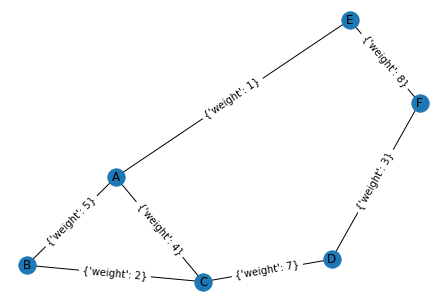

i:  A
com:  {'A', 'B'}
k_i:  10
m:  30
tot:  12.0
ki_in:  5
dM:  3.0
lc:  5.0
kc:  5
mod:  0.6483333333333333


In [5]:
g = test_graph()
plotGraph(g)

M_com = {'A': {'A', 'B'}, 'B': set(), 'C': set(), 'D': {'C', 'D'}, 'E': {'E', 'F'}, 'F': set()} 

i = "A"
j = "B"
com = M_com[i]

print("i: ", i)
print("com: ", com)

# Calculates the sum of the weights of all edges incident in node i
k_i = calc_ki(g, i)
print("k_i: ", k_i)

# Calculates the sum of the weights of all edges in the graph
m = calc_m(g)
print("m: ", m)

# Calculates the sum of the weights of all edges to nodes in com
tot = calc_tot(g, com)
print("tot: ", tot)

# Calculates the sum of the weights of edges from node i to nodes in com
ki_in = calc_ki_in(g,i,com)
print("ki_in: ", ki_in)

# Calculates the delta Modularity
dM = calc_deltaMm(g,i,com,m)
print("dM: ", dM)

# Calculates the sum of the weights of all intra-community edges in com
lc = calc_lc(g,com)
print("lc: ", lc)

# Calculates the sum of degrees of the nodes in com
kc = calc_kc(g,com)
print("kc: ", kc)

# Calculates the modularity
mod = calc_mod(g,M_com,m)
print("mod: ", mod)

### b) Community Aggregation
After finishing the first step, all nodes belonging to the same community are merged into a single node. This step also generates self-loops which are the sum of all links inside a given community, before being collapsed into one node.

**Notes:**
* You are free to implement everything on your own (as long as the result is correct), but a possible way to solve it is by working with a dictionary containing the new partition.
* It is useful to add an attribute 'name' to the original graph's nodes in order to preserve the indices as they are reset when creating subgraphs.
* When testing your function, you can use the function `plotGraph` defined below to get a visual verification.
* `M_com` is a dictionary that contains the new community partition (e.g. M_com equals {'A': {'A', 'B'}, 'B': set(), 'C': set(), 'D': {'C', 'D'}, 'E': {'E', 'F'}, 'F': set()})

In [6]:
def plotGraph(g):
    # Create positions of all nodes and save them
    pos = nx.spring_layout(g)

    # Draw the graph according to node positions
    nx.draw(g, pos, with_labels=True)

    # Create edge labels
    labels = {e: str(g.get_edge_data(*e)) for e in g.edges}

    # Draw edge labels according to node positions
    nx.draw_networkx_edge_labels(g, pos, edge_labels=labels)

    plt.show()

In [7]:
def mergeCommunities(g, M_com):
    # TODO:
    # add name attribute to graph
    attrs = {v: {"name": v} for v in g.nodes}
    nx.set_node_attributes(g, attrs)

    g_new = g
    # iterate com over M_com
    for c_k, c_v in M_com.items():
        if c_v:
            w = 0
            # contract nodes in com
            for c in c_v:
                # plotGraph(g_new)
                g_new = nx.contracted_nodes(g_new, c_k, c, True)
                # add up weights of self loops
                if c in g[c]:
                    w += g[c][c]["weight"]
            # assign calc_lc to weight of contracted node
            if c_k in g_new[c_k]:
                g_new[c_k][c_k]["weight"] = w + calc_lc(g, c_v)

            # get all nodes n connected to com
            n = []
            [n.append(neighbor) for neighbor in g_new.neighbors(c_k) if neighbor != c_k]
            # assign calc_ki_in(g, n, com) to weight of edge
            for neigh in n:
                g_new[c_k][neigh]["weight"] = calc_ki_in(g, neigh, c_v)

            # update graph
            g = g_new
            
    return g_new


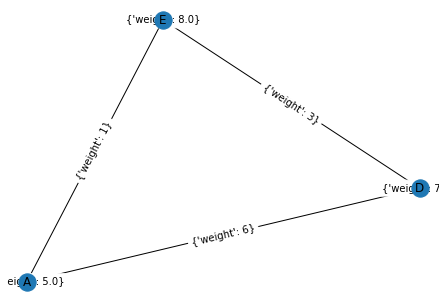

In [8]:
M_com = {'A': {'A', 'B'}, 'B': [], 'C': [], 'D': {'C', 'D'}, 'E': {'E', 'F'}, 'F': set()} 
l = mergeCommunities(g, M_com)
plotGraph(l)

### c) Louvain Loop
The next step is to implement the core functionality. Determine the best partition based on modularity in the current graph and use your function `mergeCommunities` to merge accordingly. This is repeated until no improvement can be made. The final output is the graph with the best clustering and the corresponding modularity value.

**Notes:**
* It may be helpful to look at the lecture's slides on the topic again for understanding modularity and clustering algorithms.
* Use this [pseudo-code](https://miro.medium.com/max/2400/1*gglKE-X25TSwtw9kG0D5vg.png) [3] as help, the algorithm and pseudo-code is explained on this [website](https://towardsdatascience.com/louvain-algorithm-93fde589f58c) [2], that we have already linked above.
* You are free to implement everything on your own (as long as the result is correct), but the given code construct should give you a good starting point.
* Our test graph is taken from this [website](https://www.statworx.com/de/blog/community-detection-with-louvain-and-infomap/) [4] which once again explains the algorithm and you can lookup the correct partition of said graph there.
* For testing purposes you might want to use more than one graph. Remember to assign weights to your graphs edges as we did below on the Krackhardt Kite Graph.

In [9]:
# Krackhardt Kite Graph with assigned weight=1
def krackhardt_graph():
    g = nx.krackhardt_kite_graph()
    for e in g.edges():
        g[e[0]][e[1]]["weight"] = 1
    return g

# Test graph from linked website
def test_graph():
    g = nx.Graph()
    g.add_node("A")
    g.add_node("B")
    g.add_node("C")
    g.add_node("D")
    g.add_node("E")
    g.add_node("F")
    g.add_edge("A", "B", weight=5)
    g.add_edge("A", "C", weight=4)
    g.add_edge("A", "E", weight=1)
    g.add_edge("B", "C", weight=2)
    g.add_edge("C", "D", weight=7)
    g.add_edge("D", "F", weight=3)
    g.add_edge("E", "F", weight=8)
    return g

End result
Modularity: -0.0002777777777777778


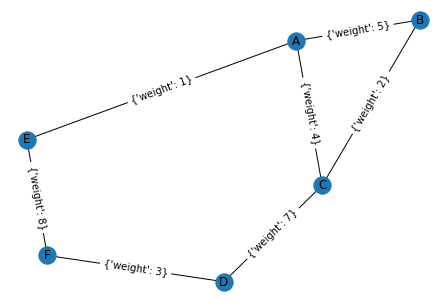

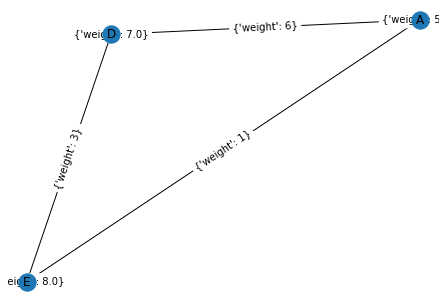

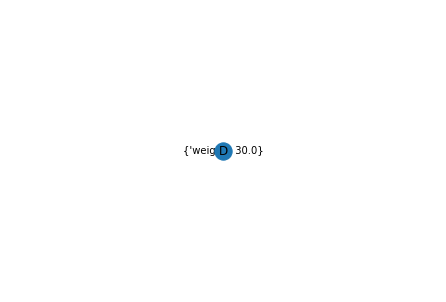

In [10]:
g = test_graph()
# Can be used for testing
# g = krackhardt_graph()

m = calc_m(g)  # TODO
graphs = []
graphs.append(g)
random.seed(42)

# Loop until no improvement can be made through merging
while True:
    V = g.nodes
    M_com = {}  # M_com is explained in sub task b)
    nodes_dict = (
        {}
    )  # A dictionary that contains all nodes as keys and tracks their respective community

    # TODO: Initialize M_com and calculate mod_new
    for i in V:
        M_com[i] = list(i)
        nodes_dict[i] = i
    mod_new = calc_mod(g, M_com, m)

    # Loop until no node movement/improvement can be made
    while True:

        # randomly sample the nodes
        mod = mod_new
        M_com_old = copy.deepcopy(M_com)
        v_random = random.sample(V, k=len(V))

        # TODO: Loop over all nodes and communities in order to find the best partition
        for v in v_random:

            # get current community of node v
            # set mod as current best modularity
            best_com = nodes_dict[v]
            best_inc = mod

            # get neighbors of v
            n = []
            [n.append(neighbor) for neighbor in g.neighbors(v) if neighbor != v]

            # iterate over communities
            for c_k, c_v in M_com.items():
                for neigh in n:
                    if v not in c_v and neigh in c_v:
                        
                        # move node v from current community to c_k
                        com = copy.deepcopy(M_com)
                        com[best_com].remove(v)
                        com[c_k].append(v)

                        # calculate modularity of the change
                        mod_new = calc_mod(g, com, m)

                        # check if modularity is higher after change
                        if mod_new > best_inc:
                            # apply changes to M_com
                            M_com[best_com].remove(v)
                            best_com = c_k
                            M_com[best_com].append(v)

                            # update values
                            nodes_dict[v] = best_com
                            best_inc = mod_new
                            mod = mod_new

            # delete nodes that are in new best community with v
            for c1 in M_com[best_com]:
                v_random.remove(c1)
        
        # stop if communities don't change anymore
        if M_com == M_com_old:
            break

    # TODO: Merge the communities with your function if an improvement is made
    g_new = mergeCommunities(g, M_com)
    mod_new = calc_mod(g_new, M_com, m)

    # stop if graph doesn't change anymore
    if g.edges != g_new.edges and g.nodes != g_new.nodes:
        g = copy.deepcopy(g_new)
        graphs.append(g_new)
        mod = mod_new
    else:
        break

print("End result")
print("Modularity: " + str(mod))

for graph in graphs:
    plotGraph(graph)

## Task 3.2: Clustering Comparison 
Now you have implemented a clustering algorithm yourself, it is time to compare performances of different clustering approaches. It is your task to compare algorithms "K-means" and "Gaussian Mixture Models" and evaluate their results.

### a) The dataset
First we create a dataset. The dataset contains samples from two overlapping Gaussian distributions as well as a uniform distribution. You can change the distributions to different values for testing and answering questions below but besides that you do not have to edit this code block.

In [11]:
import numpy.random as npr

# Create dataset with 2 Gaussian distributions and a uniform distribution
def create_dataset(datapoints=3000):
    
    # Create dataset consisting only of zeros
    data = np.zeros([datapoints, 3])
    dist_size = datapoints//3

    # Create 2 Gaussian distributions and one uniform distribution
    gaussian_dist1 = npr.multivariate_normal(mean=[-1, 1], cov=[[2, 1],[1, 2]], size=(dist_size))
    gaussian_dist2 = npr.multivariate_normal(mean=[1, 5], cov=[[3, 1],[2, 1]], size=(dist_size))
    uniform_dist = npr.uniform([5, -3], [10, 5], size=(dist_size, 2))

    # Merge all distributions into one dataset
    data[:dist_size, :2] = gaussian_dist1
    data[:dist_size, 2] = np.asarray([0]*dist_size)
    data[dist_size:2*dist_size, :2] = gaussian_dist2
    data[dist_size:2*dist_size, 2] = np.asarray([1]*dist_size)
    data[2*dist_size:, :2] = uniform_dist
    data[2*dist_size:, 2] = np.asarray([2]*dist_size)

    return data

### b) Clustering
With a dataset in your hands, you can now define a K-means and GMM model that compute clusterings. Use the same number of max iterations for both, so they are comparable to each other. 

First you have to initialize the models and then compute clusterings on our our data.

**Notes:**
* You do not have to code anything yourself, just use the pre-defined functions.
* Think about an optimal number of clusters for each case.

In [12]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

data = create_dataset(300)

k = 2 # because two gaussians
iterations = 1000
tol = 1e-3

# TODO: Initialize K-Means and Gaussian Mixture models
k_means = KMeans(n_clusters=k, tol=tol, max_iter=iterations, n_init=10, random_state=42)
gmm = GaussianMixture(n_components=k, tol=tol, max_iter=iterations, n_init=10, random_state=42)

# TODO: Fit and predict the data
y_kmeans = k_means.fit_predict(data)
y_gmm = gmm.fit_predict(data)


/home/user/miniconda3/envs/sc/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: covariance is not positive-semidefinite.
  if sys.path[0] == '':


### c) Plotting and evaluation
Finally you can plot the results. You can change different parameters in the code blocks above to answer the following questions:

* What kind of effect does the amount of datapoints have?
* Describe the kind of error (shape) K-means/GMM produce!
* Compare the results of K-means and GMM with different parameter settings

**TODO: Write your observations here**  
* Effect of amount of data points:

More data makes the clustering more accurate and helps in dividing the two clusters apart

* Error:

Idk?

* Comparison of K-means and GMM:

Some points at the top are classfied differently. 

#### K-means clustering
**Note**: Depending on the amount of datapoints you have, it may take a while to display.

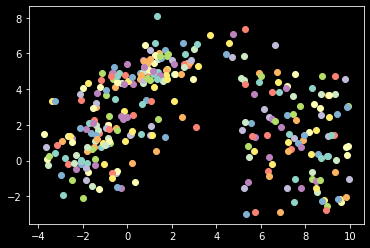

In [13]:
# display data
for i, point in enumerate(data):
    plt.scatter(point[0],point[1])
plt.show()

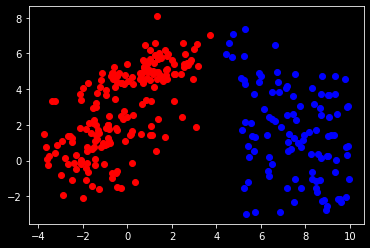

In [14]:
colors = ["r", "b", "g"]

# Color the datapoints according to the kmeans prediction

for i, point in enumerate(data):
    plt.scatter(point[0],point[1],color=colors[y_kmeans[i]])
    
plt.show()

#### GMM clustering
**Note**: Depending on the amount of datapoints you have, it may take a while to display.

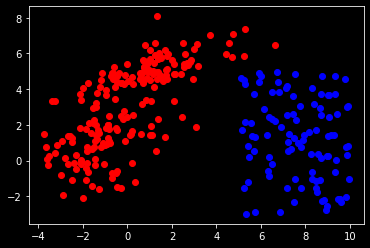

In [15]:
colors = ["r", "b", "g"]

# Color the datapoints according to the gmm prediction

for i, point in enumerate(data):
    plt.scatter(point[0],point[1],color=colors[y_gmm[i]])
    
plt.show()

## References

[1] https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.quality.modularity.html
<br>[2] https://towardsdatascience.com/louvain-algorithm-93fde589f58c
<br>[3] https://miro.medium.com/max/2400/1*gglKE-X25TSwtw9kG0D5vg.png
<br>[4] https://www.statworx.com/de/blog/community-detection-with-louvain-and-infomap/